In [1]:
#Importing all the modules and functions 

import cv2
import imageio
from google.colab import files
import os
import tensorflow as tf
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, concatenate
from tensorflow.python.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D, Cropping2D, Conv2D, SeparableConv2D

In [2]:
#Mounting google drive

from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [3]:
#Unziping the dataset

!unzip -q "/content/gdrive/MyDrive/Dataset.zip"

In [4]:
#Providing path to the train and validation directories

train_dir= '/content/Dataset/train'
val_dir= '/content/Dataset/validation'

In [ ]:
#Basic parameters

height= 256
width= 256
batch_size= 16

In [ ]:
#Defining datagenerators and preprocessing functions

def change_image_layers(image):
  return tf.image.rgb_to_yuv(image)

datagenerator = ImageDataGenerator(rotation_range = 90,
                                   rescale = 1.0/255.0,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   fill_mode = 'reflect',
                                   preprocessing_function = change_image_layers)

hiding_train_gen = datagenerator.flow_from_directory(train_dir,
                                               target_size = (256,256),
                                               color_mode = 'rgb',
                                               batch_size = 16,
                                               shuffle = True,
                                               interpolation = 'bicubic')

host_train_gen = datagenerator.flow_from_directory(train_dir,
                                             target_size = (256,256),
                                             color_mode = 'rgb',
                                             batch_size = 16,
                                             shuffle = True,
                                             interpolation = 'bicubic')

hiding_val_gen = datagenerator.flow_from_directory(val_dir,
                                                   target_size = (256,256),
                                                   color_mode = 'rgb',
                                                   batch_size = 16,
                                                   shuffle = True,
                                                   interpolation = 'bicubic')

host_val_gen = datagenerator.flow_from_directory(val_dir,
                                                 target_size = (256,256),
                                                 color_mode = 'rgb',
                                                 batch_size = 16,
                                                 shuffle = True,
                                                 interpolation = 'bicubic')

In [ ]:
#Defining datagenerators to give input for training

def train_gen():
  while True:
    hiding_batch = hiding_train_gen.next()
    host_batch = host_train_gen.next()
  
    yield [hiding_batch[0],host_batch[0]], [hiding_batch[0],host_batch[0]]
 
def val_gen():
  while True:
    hiding_batch = hiding_val_gen.next()
    host_batch = host_val_gen.next()
 
    yield [hiding_batch[0],host_batch[0]], [hiding_batch[0],host_batch[0]]

In [ ]:
#Defining various losses

def encoder_loss(host_input, container_image):
  loss = K.sum(K.square(host_input - container_image))
  return loss
 
def decoder_loss(input_container, recovered_image):
  beta = 0.75
  loss = beta * K.sum(K.square(input_container - recovered_image))
  return loss
 
def full_loss(y_true, y_pred):

  hiding_true, host_true = y_true[0], y_true[1]
  hiding_pred, host_pred = y_pred[0], y_pred[1]
  hiding_loss = decoder_loss(hiding_true, hiding_pred)
  host_loss = K.sum(K.square(host_true - host_pred))

  return hiding_loss + host_loss

In [ ]:
#Defining encoder architecture

def encoder_arch():
 
  hiding_input = Input(batch_shape = (16,256,256,3))
  host_input = Input(batch_shape = (16,256,256,3))
 
  n1 = Conv2D(filters = 50, kernel_size = (4,4), padding = 'same', activation = 'relu')(hiding_input)
  n2 = Conv2D(filters = 50, kernel_size = (4,4), padding = 'same', activation = 'relu')(n1)
  n3 = Conv2D(filters = 50, kernel_size = (4,4), padding = 'same', activation = 'relu')(n2)
  n4 = Conv2D(filters = 30, kernel_size = (4,4), padding = 'same', activation = 'relu')(n3)
  prepared = Conv2D(filters = 7, kernel_size = (2,2), padding = 'same', activation = 'tanh')(n4)
 
  concatenated_image = concatenate([host_input,prepared])
 
  n6 = Conv2D(filters=50, kernel_size=(4,4), padding='same', activation='relu')(concatenated_image)
  n7 = Conv2D(filters=50, kernel_size=(4,4), padding='same', activation='relu')(n6)
  n8 = Conv2D(filters=50, kernel_size=(4,4), padding='same', activation='relu')(n7)
  n9 = Conv2D(filters=50, kernel_size=(4,4), padding='same', activation='relu')(n8)
  n10 = Conv2D(filters=30, kernel_size=(2,2), padding='same', activation='relu')(n9)
  container_image = Conv2D(filters=3, kernel_size=(2,2), padding='same', activation='tanh')(n10)
 
  return Model(inputs = [hiding_input,host_input], outputs = [container_image])

In [ ]:
#Defining decoder architecture

def decoder_arch():
 
  input_container = Input(batch_shape = (16,256,256,3))
 
  N1 = Conv2D(filters = 100, kernel_size = (5,5), padding = 'same', activation = 'relu')(input_container)
  N2 = Conv2D(filters = 100, kernel_size = (5,5), padding = 'same', activation = 'relu')(N1)
  N3 = Conv2D(filters = 100, kernel_size = (5,5), padding = 'same', activation = 'relu')(N2)
  N4 = Conv2D(filters = 50, kernel_size = (5,5), padding = 'same', activation = 'relu')(N3)
  recovered_image = Conv2D(filters = 3, kernel_size = (2,2), padding = 'same', activation = 'tanh')(N4)
 
  return Model(inputs = [input_container], outputs = [recovered_image])

In [ ]:
#defining autoencoder architecture

def autoencoder_arch():
 
  encoder = encoder_arch()
  decoder = decoder_arch()
 
  hiding_input = Input(batch_shape = (16,256,256,3))
  host_input = Input(batch_shape = (16,256,256,3))
 
  encoder.compile(optimizer = Adam(lr = 1e-4), loss = encoder_loss, metrics = ['accuracy'])
  decoder.compile(optimizer = Adam(lr = 1e-4), loss = decoder_loss, metrics = ['accuracy'])
 
  container_images = encoder([hiding_input, host_input])
  recovered_image = decoder([container_images])
 
  autoencoder = Model(inputs = [hiding_input,host_input], outputs = [recovered_image,container_images])
  autoencoder.compile(optimizer = Adam(lr = 1e-4), loss = full_loss, metrics = ['accuracy'])
 
  return encoder, decoder, autoencoder

In [ ]:
encoder, decoder, autoencoder = autoencoder_arch()

In [ ]:
autoencoder.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(16, 256, 256, 3)]  0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(16, 256, 256, 3)]  0                                            
__________________________________________________________________________________________________
model (Functional)              (16, 256, 256, 3)    242020      input_4[0][0]                    
                                                                 input_5[0][0]                    
__________________________________________________________________________________________________
model_1 (Functional)            (16, 256, 256, 3)    633453      model[0][0]                

In [ ]:
#Setting callbacks and checkpoints

weights_file=os.path.join("/content/gdrive/MyDrive/Cats and Dogs Dataset/",'Final.hdf5')
 
checkpoint = ModelCheckpoint(weights_file, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)
 
# autoencoder.load_weights(weights_file)
 
 
callbacks= [checkpoint]

In [ ]:
#training the model

history= autoencoder.fit(x = train_gen(),
                         epochs= 100,
                         validation_data= val_gen(),
                         shuffle= True,
                         callbacks = callbacks,
                         steps_per_epoch= 125,
                         validation_steps= 62.5)

Epoch 1/100
125/125 [==============================] - 301s 2s/step - loss: 29999.8927 - model_1_loss: 13507.3297 - model_loss: 16492.5639 - model_1_accuracy: 0.9519 - model_accuracy: 0.8465 - val_loss: 3265.6113 - val_model_1_loss: 1445.4866 - val_model_loss: 1820.1241 - val_model_1_accuracy: 0.9843 - val_model_accuracy: 0.9847

Epoch 00001: val_loss improved from inf to 3265.61133, saving model to /content/gdrive/MyDrive/Cats and Dogs Dataset/Final.hdf5
Epoch 2/100
125/125 [==============================] - 261s 2s/step - loss: 2919.3123 - model_1_loss: 1419.3842 - model_loss: 1499.9286 - model_1_accuracy: 0.9938 - model_accuracy: 0.9928 - val_loss: 2213.8125 - val_model_1_loss: 1279.9288 - val_model_loss: 933.8838 - val_model_1_accuracy: 0.9851 - val_model_accuracy: 0.9844

Epoch 00002: val_loss improved from 3265.61133 to 2213.81250, saving model to /content/gdrive/MyDrive/Cats and Dogs Dataset/Final.hdf5
Epoch 3/100
125/125 [==============================] - 260s 2s/step - loss: 1

In [ ]:
#Loading the weights from the weight file

autoencoder.load_weights(weights_file)

In [ ]:
#Providing path to various directories for saving and retreiving images for testing

host_dir = "/content/gdrive/MyDrive/Test/Host"
hiding_dir = "/content/gdrive/MyDrive/Test/Hiding"
container_dir = "/content/gdrive/MyDrive/Test/Container"
revealed_dir = "/content/gdrive/MyDrive/Test/Revealed"

In [ ]:
#Defining datagenerators for testing the model
#Add host, hiding images to the respective directories to read the images and get the container images

host_test_gen = datagenerator.flow_from_directory(host_dir,
                                                  target_size = (256,256),
                                                  color_mode = 'rgb',
                                                  batch_size = 16,
                                                  shuffle = True,
                                                  interpolation = 'bicubic')

hiding_test_gen = datagenerator.flow_from_directory(hiding_dir,
                                                    target_size = (256,256),
                                                    color_mode = 'rgb',
                                                    batch_size = 16,
                                                    shuffle = True,
                                                    interpolation = 'bicubic')

Found 16 images belonging to 1 classes.
Found 16 images belonging to 1 classes.


In [ ]:
# Use following two lines to get hiding and host batch images from the above directories
# batch_test_hiding= hiding_test_gen.next()[0]
# batch_test_host= host_test_gen.next()[0]
# preds=encoder.predict([batch_hiding,batch_host])

#Use following two lines to get hiding and host batch images from dataset
batch_hiding= hiding_val_gen.next()[0]
batch_host= host_val_gen.next()[0]
preds=encoder.predict([batch_hiding,batch_host])

In [ ]:
for i in range(batch_size):
    
    fig = plt.figure(figsize=(10,5))
    
    ax1 = fig.add_subplot(1,3,1)
    plt.title('Hiding')
    ax1.imshow(tf.image.yuv_to_rgb(batch_hiding[i]))
    image = np.array(tf.image.yuv_to_rgb(batch_hiding[i]))

    #Comment the following line, if the images are taken from the Hiding folder and not from database 
    imageio.imsave(hiding_dir + "/Hiding Images" + "/hiding" + str(i) + ".png", image)  

    ax2 = fig.add_subplot(1,3,2)
    ax2.set_title('Host')
    ax2.imshow(tf.image.yuv_to_rgb(batch_host[i]))
    image = np.array(tf.image.yuv_to_rgb(batch_host[i]))

    #Comment the following lines, if the images are taken from Host folder and not from database
    imageio.imsave(host_dir + "/Host Images" + "/host" + str(i) + ".png", image)

    ax3 = fig.add_subplot(1,3,3)
    ax3.set_title('Container')
    ax3.imshow(tf.image.yuv_to_rgb(preds[i]))
    image = np.array(tf.image.yuv_to_rgb(preds[i]))
    imageio.imsave(container_dir + "/Container Images" + "/container" + str(i) + ".png", image)

    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#Defining datagenerator to read container images from drive
#This is one of the way to decode the images
#Code for decoding a single image is shown in the following cells

container_test_gen = datagenerator.flow_from_directory(container_dir,
                                                       target_size = (256,256),
                                                       color_mode = 'rgb',
                                                       batch_size = 16,
                                                       shuffle = True,
                                                       interpolation = 'bicubic')

Found 17 images belonging to 1 classes.


In [ ]:
#Use the following lines if decoding is to be done on the images obtained from the above encoder 

dec_preds= decoder.predict(preds)
print(dec_preds.shape)
for i in range(batch_size):
    
    fig = plt.figure(figsize=(10,5))
    
    ax1 = fig.add_subplot(1,3,1)
    ax1.set_title('Hiding')
    ax1.imshow(tf.image.yuv_to_rgb(batch_hiding[i]))
    
    
    ax2 = fig.add_subplot(1,3,2)
    ax2.set_title('Cover')
    ax2.imshow(tf.image.yuv_to_rgb(batch_host[i]))

    ax3 = fig.add_subplot(1,3,3)
    ax3.set_title('Revealed')
    ax3.imshow(tf.image.yuv_to_rgb(dec_preds[i]))
    image = np.array(tf.image.yuv_to_rgb(dec_preds[i]))
    imageio.imsave(revealed_dir + "/revealed" + str(i) + ".png", image)
    
    
    
    plt.show()

#Use the following code if decoding is to be done on the images from container images folder otherwise comment this section

# batch_container = container_test_gen.next()[0]
# dec_preds = decoder.predict(batch_container)

# for i in range(batch_size):
    
#     fig = plt.figure(figsize=(10,5))

    

#     ax1 = fig.add_subplot(1,4,3)
#     ax1.set_title('Container')
#     ax1.imshow(tf.image.yuv_to_rgb(batch_container[i]))

#     ax2 = fig.add_subplot(1,4,4)
#     ax2.set_title('Revealed')
#     ax2.imshow(tf.image.yuv_to_rgb(dec_preds[i]))
#     image = np.array(tf.image.yuv_to_rgb(dec_preds[i]))
#     imageio.imsave(revealed_dir + "/revealed" + str(i) + ".png", image)
    
#     plt.show()

Output hidden; open in https://colab.research.google.com to view.

Saving container0.png to container0.png


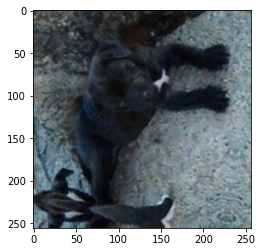

In [ ]:
#Use this code to decode a single image

uploaded = files.upload()
h= 256
w= 256

image = cv2.imread("/content/container0.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = tf.image.rgb_to_yuv(image/255.0)
array = np.zeros((1,h,w,3))
array[0] = image

revealed = decoder.predict(array)
plt.imshow(tf.image.yuv_to_rgb(revealed[0]))
revealed = np.array(tf.image.yuv_to_rgb(revealed[0]))
imageio.imsave(revealed_dir + "predicted" + ".png", revealed)

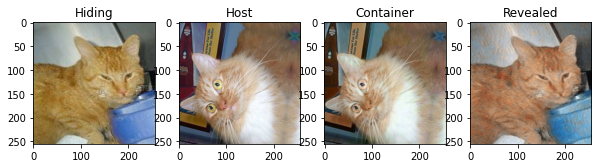

In [ ]:
i = 1

fig = plt.figure(figsize=(10,5))
    
ax1 = fig.add_subplot(1,4,1)
plt.title('Hiding')
ax1.imshow(tf.image.yuv_to_rgb(batch_hiding[i]))
image1 = np.array(tf.image.yuv_to_rgb(batch_hiding[i]))
imageio.imsave("/content/gdrive/MyDrive/Test"+ "/HidingCNN" + ".png", image1)


ax2 = fig.add_subplot(1,4,2)
ax2.set_title('Host')
ax2.imshow(tf.image.yuv_to_rgb(batch_host[i]))
image2 = np.array(tf.image.yuv_to_rgb(batch_host[i]))
imageio.imsave("/content/gdrive/MyDrive/Test"+ "/HostCNN" + ".png", image2)



ax3 = fig.add_subplot(1,4,3)
ax3.set_title('Container')
ax3.imshow(tf.image.yuv_to_rgb(preds[i]))
image3 = np.array(tf.image.yuv_to_rgb(preds[i]))
imageio.imsave("/content/gdrive/MyDrive/Test"+ "/ContainerCNN" + ".png", image3)


ax4 = fig.add_subplot(1,4,4)
ax4.set_title('Revealed')
ax4.imshow(tf.image.yuv_to_rgb(dec_preds[i]))
image4 = np.array(tf.image.yuv_to_rgb(dec_preds[i]))
imageio.imsave("/content/gdrive/MyDrive/Test"+ "/RevealedCNN" + ".png", image4)

plt.show()


